<span style="font-size:50px"><strong>ML4HC Project 1 - Task 3</strong></span>


In [101]:
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score


# Define paths
data_dir = "../ml4h_data/p1/"#"data"

pd.set_option('display.max_columns', None)


# Transformer Model - Q2.3

### Model and training loop

In [102]:
class Transformer(nn.Module):
    def __init__(self, input_dim, model_dim=64, num_heads=4, num_layers=2, num_classes=1, max_len=49,dropout=0.1):
        super().__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.cls_head = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, F)
        x = self.input_proj(x)                     # -> (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1)]  # add position info
        x = self.transformer(x)                    # -> (B, T, D)
        x = x.mean(dim=1)                          # average pooling
        return self.cls_head(x).squeeze(-1)


In [109]:
def train_transformer(model, dataloader, val_dataloader=None, epochs=10, lr=1e-3, weight_decay=0.0, device="cuda" if torch.cuda.is_available() else "cpu", checkpoint_path="best_model.pt"):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.BCEWithLogitsLoss()

    history = {"train_loss": [], "val_loss": [], "val_auroc": [], "val_auprc": []}
    best_auroc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        history["train_loss"].append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

        if val_dataloader:
            auroc, auprc, val_loss = evaluate_transformer(model, val_dataloader, device)
            history["val_loss"].append(val_loss)
            history["val_auroc"].append(auroc)
            history["val_auprc"].append(auprc)
            print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")

            if auroc > best_auroc:
                best_auroc = auroc
                best_state = model.state_dict()

    if best_state:
        torch.save(best_state, checkpoint_path)
        print(f"✅ Best model saved with AUROC = {best_auroc:.4f} at {checkpoint_path}")

    plot_training_curves(history)
    return history

In [112]:

def plot_training_curves(history):
    epochs_range = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    if history["val_loss"]:
        plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["val_auroc"], label="AUROC")
    plt.xlabel("Epoch"); plt.ylabel("AUROC"); plt.title("Validation AUROC")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["val_auprc"], label="AUPRC")
    plt.xlabel("Epoch"); plt.ylabel("AUPRC"); plt.title("Validation AUPRC")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [105]:

def evaluate_transformer(model, dataloader, device):
    model.eval()
    all_probs, all_labels = [], []
    total_loss = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch).squeeze()
            loss = criterion(logits, y_batch)
            total_loss += loss.item()
            probs = torch.sigmoid(logits).cpu()
            all_probs.append(probs)
            all_labels.append(y_batch.cpu())

    probs = torch.cat(all_probs)
    labels = torch.cat(all_labels)

    auroc = roc_auc_score(labels, probs)
    auprc = average_precision_score(labels, probs)
    val_loss = total_loss / len(dataloader)

    print(f"Val AUROC: {auroc:.4f}  AUPRC: {auprc:.4f}  Val Loss: {val_loss:.4f}")
    return auroc, auprc, val_loss


In [106]:
def get_data(split="train"):
    letter_map = {"train": "a", "val": "b", "test": "c"}
    letter = letter_map[split]
    df = pd.read_parquet(f"data_{letter}_scaled.parquet")

    df = df.sort_values(by=["RecordID", "Time"])

    # Move RecordID and Time to the front
    cols = ["RecordID", "Time"] + [col for col in df.columns if col not in ["RecordID", "Time"]]
    df = df[cols]

    # Remove label from features
    features = [col for col in df.columns if col not in ["RecordID", "Time", "In-hospital_death"]]

    # Group time series per patient
    grouped = df.groupby("RecordID")[features].apply(lambda x: x.to_numpy()).tolist()
    assert all(x.shape == (49, 40) for x in grouped), "Not all patients have shape (49, 41)"

    # Convert to tensor
    X = torch.stack([torch.tensor(x, dtype=torch.float32) for x in grouped])  # (N, 49, 41)

    # Extract labels
    y = torch.tensor(df.groupby("RecordID")["In-hospital_death"].first().values, dtype=torch.float32)

    dataset = TensorDataset(X, y) 
    return dataset


### Testing

In [ ]:
train_dataset = get_data("train")
val_dataset = get_data("val")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



Epoch 1/5 - Train Loss: 0.3771
Val AUROC: 0.7804  AUPRC: 0.4161  Val Loss: 0.3891
Val AUROC: 0.7804  AUPRC: 0.4161  Val Loss: 0.3891
Epoch 2/5 - Train Loss: 0.3460
Val AUROC: 0.8156  AUPRC: 0.4347  Val Loss: 0.3472
Val AUROC: 0.8156  AUPRC: 0.4347  Val Loss: 0.3472
Epoch 3/5 - Train Loss: 0.3394
Val AUROC: 0.7921  AUPRC: 0.4121  Val Loss: 0.3428
Val AUROC: 0.7921  AUPRC: 0.4121  Val Loss: 0.3428
Epoch 4/5 - Train Loss: 0.3295
Val AUROC: 0.8160  AUPRC: 0.4669  Val Loss: 0.3277
Val AUROC: 0.8160  AUPRC: 0.4669  Val Loss: 0.3277
Epoch 5/5 - Train Loss: 0.3222
Val AUROC: 0.8250  AUPRC: 0.4338  Val Loss: 0.3324
Val AUROC: 0.8250  AUPRC: 0.4338  Val Loss: 0.3324
✅ Best model saved with AUROC = 0.8250 at best_model.pt


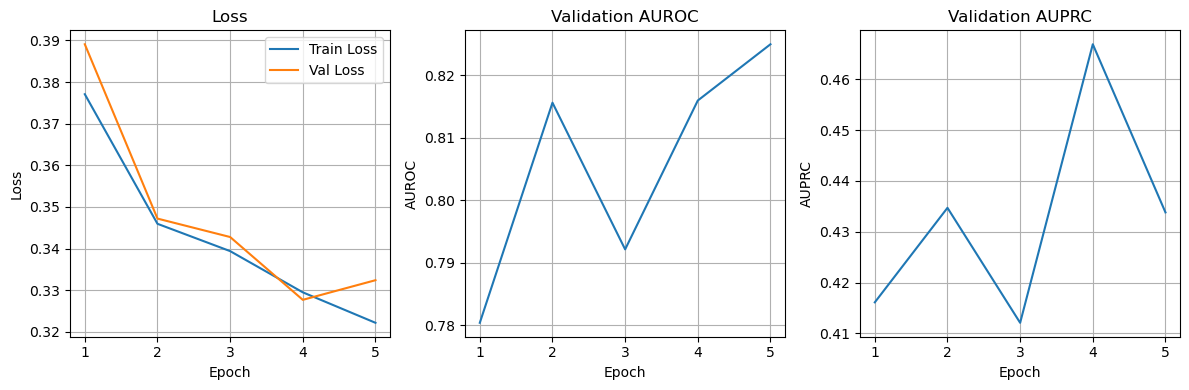

{'train_loss': [0.3770900852680206,
  0.3459504663348198,
  0.3393866552114487,
  0.3294855838418007,
  0.3221640855073929],
 'val_loss': [0.38909220319986343,
  0.3472037472724915,
  0.3427737327814102,
  0.3276813313961029,
  0.33239803874492646],
 'val_auroc': [np.float64(0.7803989584359302),
  np.float64(0.8156086870875603),
  np.float64(0.7921452813618308),
  np.float64(0.8159587991234118),
  np.float64(0.8249588586296334)],
 'val_auprc': [np.float64(0.41609890562809737),
  np.float64(0.43470610436630386),
  np.float64(0.4120700264950645),
  np.float64(0.46691428721412376),
  np.float64(0.4338068115599165)]}

In [115]:
model = Transformer(input_dim=40, model_dim=64, num_layers=3, dropout=0.1)


train_transformer(model, train_loader, val_dataloader=val_loader, epochs=5, lr=1e-3)

## Q2.3b: Tokenizing Time-Series Data and Transformers 

In [118]:
df = pd.read_parquet(f"data_a_scaled_nonImputed.parquet")
df["Time"] = df["Time"] / df["Time"].max()


In [119]:
df

,Time,RecordID,Age,Gender,Height,ICUType,Weight,BUN,Creatinine,GCS,Glucose,HCO3,HCT,HR,K,Mg,NIDiasABP,NIMAP,NISysABP,Na,Platelets,RespRate,Temp,TroponinT,Urine,WBC,ALP,ALT,AST,Albumin,Bilirubin,FiO2,PaCO2,PaO2,pH,DiasABP,MAP,SaO2,SysABP,Lactate,Cholesterol,TroponinI,In-hospital_death
0,0.000000,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.020833,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.041667,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,0.905372,NaN,NaN,NaN,1.420996,NaN,NaN,-1.014629,-0.570817,0.029915,NaN,NaN,0.426204,-0.608415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.062500,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,1.627492,1.053339,NaN,4.182595,-2.574523,-1.037699,1.477224,1.664938,1.745415,-0.346486,-0.030079,0.216447,0.179207,0.964105,0.243589,NaN,-0.300136,0.272988,0.56182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.083333,132592.0,-1.665694,0.0,NaN,3.0,-0.451334,NaN,NaN,NaN,NaN,NaN,NaN,1.420996,NaN,NaN,-0.680558,-0.391022,-0.063351,NaN,NaN,0.791436,NaN,NaN,0.075019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195995,0.916667,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.465118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.594195,1.406126,NaN,1.331414,NaN,NaN,NaN,0
195996,0.937500,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,0.905372,NaN,NaN,NaN,0.408890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337238,NaN,0.317015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.772969,1.529577,NaN,1.375968,NaN,NaN,NaN,0
195997,0.958333,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.858715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.831144,1.159226,NaN,1.465077,NaN,NaN,NaN,0
195998,0.979167,141565.0,-0.469709,1.0,1.217246,1.0,0.731610,NaN,NaN,NaN,NaN,NaN,NaN,0.690031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.876725,0.480249,NaN,0.484884,NaN,NaN,NaN,0


In [ ]:
records = []

for _, row in df.iterrows():
    record = []

    record.append(row["RecordID"])                      # Row 1: RecordID  
    record.append(row["Time"])                          # Row 2: Time  
    record.append([col for col in df.columns if col not in ["RecordID", "Time"]])  # Row 3: Variable names  
    record.append([row[col] for col in df.columns if col not in ["RecordID", "Time"]])  # Row 4: Variable values  

    records.append(record)

new_df = pd.DataFrame(records).T.reset_index(drop=True)


In [ ]:
new_df.iloc[:, :20]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0,132592.0
1,0.0,0.020833,0.041667,0.0625,0.083333,0.104167,0.125,0.145833,0.166667,0.1875,0.208333,0.229167,0.25,0.270833,0.291667,0.3125,0.333333,0.354167,0.375,0.395833
2,"[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr...","[Age, Gender, Height, ICUType, Weight, BUN, Cr..."
3,"[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333...","[-1.6656936284736743, 0.0, nan, 3.0, -0.451333..."


#  Pretraining and linear probes - Q3.1

#  Simulate label scarcity - Q3.2

#  Visualising learned representations - Q3.3
